In [1]:
# Load used Python packages
import numpy as np
import pandas as pd
from SimPEG.utils import surface2ind_topo, model_builder
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from pymatsolver import Pardiso as Solver
import matplotlib.pyplot as plt

>> Use cython version


## Step1: Load ERT resistivity data

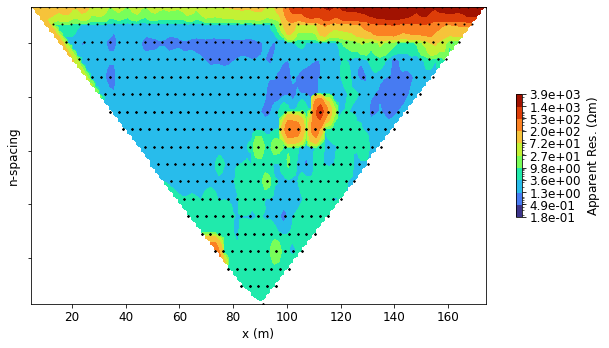

In [4]:
# initialize data_io object
data_io = dc.IO()
# read  data in ascii format
dc_data = np.loadtxt("../data/EBWS0724.dat", skiprows=9)
# parse out A, B, M, N electrodes and appparent resistivity 
a = dc_data[:,1:3] # A: + current electrode locations [m]
b = dc_data[:,3:5] # B: - current electrode locations [m]
m = dc_data[:,5:7] # M: + potential electrode locations [m]
n = dc_data[:,7:9] # N: - potential electrode locations [m]
rho = dc_data[:,9] # rho: apparent resistivity [ohm-m]
# read topography
topo = np.loadtxt('../data/topo', delimiter=',')
# pad topography valiues (given values did not cover the inversion domain)
topo = np.vstack((np.array([-100, 0]), topo, np.array([300, 2.8733])))
# create a survey object from the data_io object
survey = data_io.from_abmn_locations_to_survey(
    a, b, m, n, 
    survey_type='dipole-dipole', # don't be confused dipole-dipole includes any type of arrays using four electrodes system
    data_dc=rho, 
    data_dc_type='apparent_resistivity'# input data type
)
# plot ert data on a pseudo-section
data_io.plotPseudoSection(cmap='turbo')

## Step2: Filter noisy data

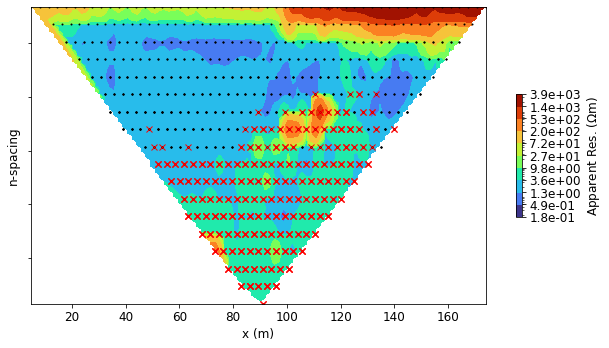

In [5]:
# define conditions to remove data
# data_io.grids indicates location of the data on a pseudo-section
inds = (data_io.grids[:,1] > 19) & (data_io.apparent_resistivity>3) | (data_io.grids[:,1]>30)
data_io.plotPseudoSection(cmap='turbo')
plt.plot(data_io.grids[inds,0], data_io.grids[inds,1], 'rx')

C:\Users\sgkan\Projects\simpeg\SimPEG\electromagnetics\static\resistivity\IODC.py:188: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")


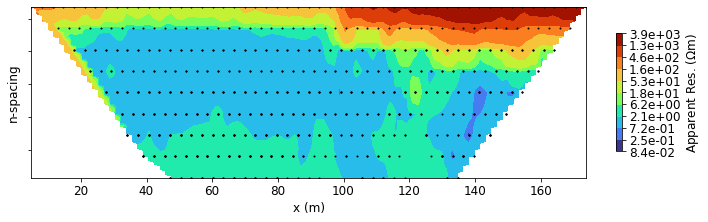

In [6]:
# Construct a new data io object with the filtered data
data_io_filtered = dc.IO()
survey = data_io_filtered.from_abmn_locations_to_survey(
    data_io.a_locations[~inds],
    data_io.b_locations[~inds],
    data_io.m_locations[~inds],
    data_io.n_locations[~inds],
    survey_type='dipole-dipole', 
    data_dc=data_io.apparent_resistivity[~inds], 
    data_dc_type='apparent_resistivity'
)
data_io_filtered.plotPseudoSection(cmap='turbo')

## Step 3: Create 2D tensor mesh

C:\Users\sgkan\Projects\simpeg\SimPEG\electromagnetics\static\resistivity\IODC.py:537: RuntimeWarning: Because the x coordinates of some topo and electrodes are the same, we excluded electrodes with the same coordinates.
  warnings.warn(


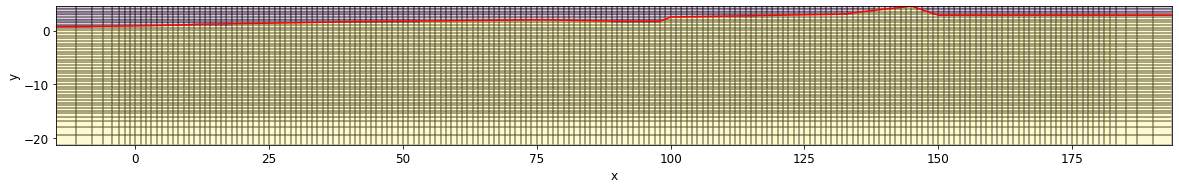

In [7]:
# create a 2D tensor mesh
mesh, _ = data_io_filtered.set_mesh(topo=topo, dx=1, dz=0.5, corezlength=20)
# define inactive cells from a given topography
ind_active = utils.surface2ind_topo(mesh, topo, method='linear')
# drape electrode locations onto the topography
survey.drape_electrodes_on_topography(mesh, ind_active)
# plot mesh, active (yellow) & inactive (blue) cells
fig, ax = plt.subplots(1,1, figsize=(20, 5))
mesh.plot_image(ind_active, grid=True, grid_opts={'alpha':0.2, 'color': 'k'}, ax=ax)
ax.plot(topo[:,0], topo[:,1], color='r')
ax.set_aspect(1)

logarithmic mean resistivity is 3.8 ohm-m


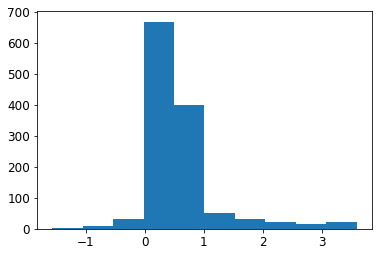

In [8]:
plt.hist(np.log10(rho))
print ("logarithmic mean resistivity is {:.1f} ohm-m".format(10**np.mean(np.log10(rho))))

## Step 4: Invert the ERT dat

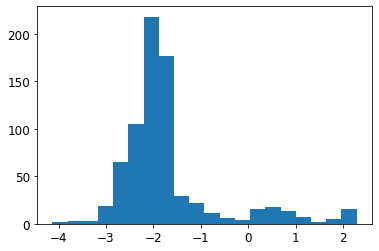

In [9]:
# create a mapping object
air_conductivity = np.log(1./1e8)
background_conductivity = np.log(1./100)
active_map = maps.InjectActiveCells(mesh, ind_active, np.exp(air_conductivity))
nC = int(ind_active.sum())
conductivity_map = active_map * maps.ExpMap()

# define model
starting_conductivity_model = background_conductivity * np.ones(nC)

# create a data object
dc_data = data.Data(survey=survey, dobs=data_io_filtered.voltages)
# assign data uncertainty or error (defined as standard deviation)
standard_deviation = 0.05 * np.abs(dc_data.dobs) + 1e-2
dc_data.standard_deviation = standard_deviation
out = plt.hist(np.log10(data_io_filtered.voltages), bins=20)

In [10]:
# create a simulation object
simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, sigmaMap=conductivity_map, Solver=Solver, storeJ=True, miniaturize=True
)

C:\Users\sgkan\Projects\simpeg\SimPEG\utils\code_utils.py:413: FutureWarning: Solver has been deprecated, please use simulation.solver. It will be removed in version 0.16.0 of SimPEG.
  warnings.warn(message, FutureWarning)
C:\Users\sgkan\Projects\simpeg\SimPEG\utils\code_utils.py:420: FutureWarning: Solver has been deprecated, please use simulation.solver. It will be removed in version 0.16.0 of SimPEG.
  warnings.warn(message, FutureWarning)


In [62]:
# create a data misfit object
dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)

# create the regularization (model objective function). here, 'p' defines the
# the norm of the smallness term, 'px' defines the norm of the smoothness
# in x and 'pz' defines the norm of the smoothness in z.
regmap = maps.IdentityMap(nP=int(ind_active.sum()))

reg = regularization.Sparse(
    mesh,
    indActive=ind_active,
    mref=starting_conductivity_model,
    mapping=regmap,
    gradientType="total",
    alpha_s=1e-5,
    alpha_x=1,
    alpha_y=0.5,
)

reg.mrefInSmooth = True  # Include reference model in smoothness

p = 2
px = 1
pz = 0
reg.norms = np.c_[p, px, pz]

# define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach.
opt = optimization.InexactGaussNewton(maxIter=40, maxIterCG=30)

# here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

#######################################################################
# define DC Inversion Directives
# ------------------------------
#
# here we define any directives that are carried out during the inversion. This
# includes the cooling schedule for the trade-off parameter (beta), stopping
# criteria for the inversion and saving inversion results at each iteration.
#

# reach target misfit for L2 solution, then use IRLS until model stops changing.
update_IRLS = directives.Update_IRLS(
    max_irls_iterations=25, minGNiter=1, chifact_start=1.0,
    f_min_change=1e-4, fix_Jmatrix=False
)

# defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)

# Options for outputting recovered models and predicted data for each beta.
save_dict = directives.SaveOutputDictEveryIteration()

# Apply and update sensitivity weighting as the model updates
update_sensitivity_weighting = directives.UpdateSensitivityWeights()

target = directives.TargetMisfit()
directives_list = [
    update_IRLS,
    starting_beta,
    save_dict,
#     beta_schedule,
#     target
]

#####################################################################
# Running the ERT Inversion
# ------------------------
#
# To define the inversion object, we need to define the inversion problem and
# the set of directives. We can then run the inversion.
#

# Here we combine the inverse problem and the set of directives
dc_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion
recovered_conductivity_model = dc_inversion.run(starting_conductivity_model)

C:\Users\sgkan\Projects\simpeg\SimPEG\directives\directives.py:1494: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  warnings.warn(



        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e+02  1.90e+06  0.00e+00  1.90e+06    6.36e+04      0              
   1  1.00e+02  2.60e+05  2.30e-02  2.60e+05    8.24e+03      0              
   2  5.01e+01  4.23e+04  9.11e-02  4.23e+04    1.03e+03      0   Skip BFGS  
   3  2.51e+01  1.60e+04  1.50e+00  1.60e+04    1.40e+02      0   Skip BFGS  
   4  1.25e+01  8.87e+03  4.13e+01  9.39e+03    1.44e+02      0   Skip BFGS  
   5  6.26e+00  2.56e+03  8.19e+01  3.07e+03    4.54e+02      1              
   6  3.13e+00  8.70e+02  9.99e+01  1.18e+03    2.65e+02      1              
Reached starting chifact with l2-n

In [65]:
from matplotlib.colors import LogNorm
from discretize import utils as dis_utils
core_inds, mesh_core = dis_utils.extract_core_mesh(data_io_filtered.xyzlim, mesh)

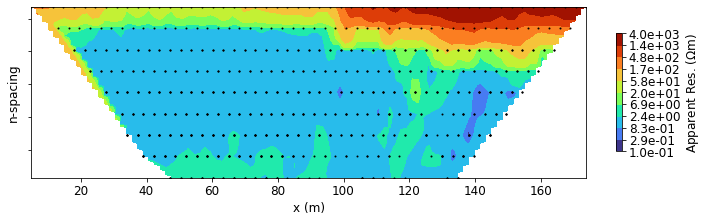

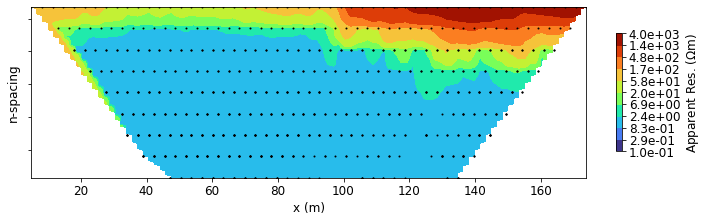

In [67]:
data_io_filtered.plotPseudoSection(cmap='turbo',clim=(0.1, 4000))
data_io_filtered.plotPseudoSection(cmap='turbo', data=inv_prob.dpred/data_io_filtered.G, clim=(0.1, 4000))

In [68]:
l2_model = recovered_conductivity_model

Text(0, 0.5, 'Elevation (m)')

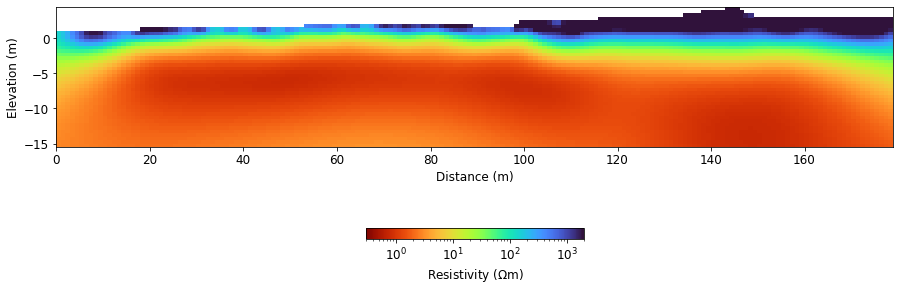

In [69]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
res = 1./(conductivity_map * inv_prob.l2model)
res[~ind_active] = np.nan
out = mesh_core.plot_image(res[core_inds], pcolor_opts={'norm': LogNorm(vmin=0.3, vmax=2000), 'cmap':'turbo_r'},ax=ax)
ax.set_aspect(1.5)
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02)
cb.set_label("Resistivity ($\Omega$m)")
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Elevation (m)")

Text(0, 0.5, 'Elevation (m)')

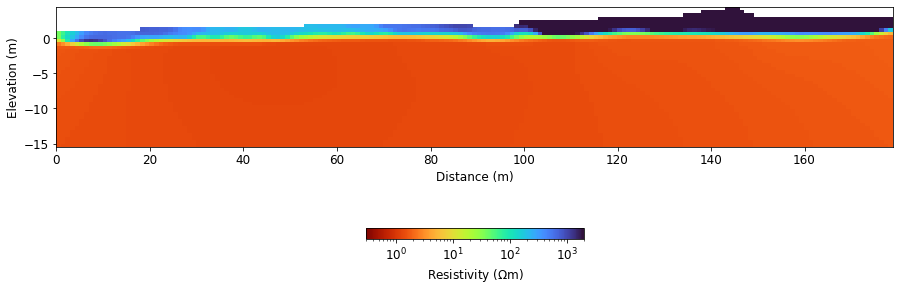

In [71]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
iteration = len(save_dict.outDict)
m = save_dict.outDict[iteration]['m']
res = 1./(conductivity_map * m)
res[~ind_active] = np.nan
out = mesh_core.plot_image(res[core_inds], pcolor_opts={'norm': LogNorm(vmin=0.3, vmax=2000), 'cmap':'turbo_r'},ax=ax)
ax.set_aspect(1.5)
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02)
cb.set_label("Resistivity ($\Omega$m)")
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Elevation (m)")